# Questão 2
Utilize redes neurais perceptrons de múltiplas camadas para aproximar as funções baixo. Para o caso dos itens 2 e 3, apresente a curva da função analítica e a curva da função aproximada pela rede neural. Apresente também a curva do erro médio de treinamento com relação ao número de épocas e a curva do erro médio com o conjunto de validação. Procure definir para cada função a arquitetura da rede neural perceptron, isto é, o número de entradas, o número de neurônios em cada camada e o número de neurônios na camada de saída.
1. $f(x_{1}, x_{2}, x_{3}) = x_{1}\oplus x_{2}\oplus x_{3} \;\; x_{1}, x_{2} \text{ e } x_{3} \in \left\{0, 1\right\}$


2. $f(x) = \dfrac{\cos 2\pi x}{1-(4x)^{2}} \dfrac{\sin(\pi x)}{\pi x} \;\;,0\leq x \leq 4\pi$


3. $f(x_{1}, x_{2}) = x_{1}^{2} + x_{2}^{2} + 2x_{1}x_{2}\cos (\pi x_{1}x_{2}) + x_{1}+x_{2}-1 \;\;,|x_{1}|\leq 1 \text{ e } |x_{2}|\leq 1$

Logo abaixo estão as bibliotecas e funções comuns a solução de todos os itens.

In [1]:
import itertools
import numpy as np
import keras.layers as kl
import keras.models as km
import keras.callbacks as kc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


## Solução da função 1
Vamos gerar nossos dados de treinamento e dados de validação manualmente. A função é bem simples e só admite 8 combinações de 0's e 1's. **OBS.:** Não usamos o `KerasRegressor` aqui.

### Construção dos vetores de treino
`x_treino` e `y_treino` serão os dados usados para treinar a rede. Todos os dados possíveis estão sendo usados para treino.

In [2]:
x_treino,y_treino = [],[]
for i in range(2):
    for j in range(2):
        for k in range(2):
            x_treino.append([i,j,k])
            if i^j^k:
                y_treino.append([1,0])
            else:
                y_treino.append([0,1])
            
x_treino = np.array(x_treino)
y_treino = np.array(y_treino)


### Construindo e compilando rede
A função custo usada foi a `categorical_crossentropy` porque o problema é de classificação entre duas classes. Ao usar esta função, a saída da rede é uma das N classes descritas no vetor gabarito. Cada classe é indexada a um valor de 0 a N-1. Sendo assim, nossas 2 classes serão chamadas de 0 e 1.

In [3]:
model = km.Sequential()  # Entrada
model.add(kl.Dense(60, activation='relu', input_dim=3)) # Primeira camada oculta
model.add(kl.Dense(60, activation='relu'))
model.add(kl.Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Ha = model.fit(x_treino, y_treino, epochs=350, verbose=0, batch_size=2)

### Validação
Vemos que os dados estimados estão bem próximos do gabarito e o erro decresceu a cada época. A função `predict()` da classe `model` calcula a probabilidade da entrada pertencer a cada classe. Isso explica por que a rede ter 2 neurônios de saída mas a resposta da predição ser só 1 valor. O que está ocorrendo é o seguinte: 
* O dado passado no argumento de `predict()` é aplicado à rede.
* O valor de cada um dos 2 neurônios de saída são calculados
* O índice do neurônio com o maior valor é retornado pela função de predição

É bom observar que o resultado do `preditc()` é um valor que inteiro representa uma classe. Por padrão, ao usar o `categorial_crossentropy`, o Keras enumera cada classe com inteiros a partir do 0. Como há duas respostas possíveis, elas serão identificadas por 0 e 1. Coindidentemente o problema que resolvemos consiste em calcular o valor de uma função cuja imagem é o conj. ${0,1}$. Sendo assim, podemos interpretar a saída da rede, não como classes, mas como o valor da função.

Amostra: [0 0 0] - Gabarito: 0 - Estimado: 0.001319299
Amostra: [0 0 1] - Gabarito: 1 - Estimado: 0.9991441
Amostra: [0 1 0] - Gabarito: 1 - Estimado: 0.9980515
Amostra: [0 1 1] - Gabarito: 0 - Estimado: 0.0015945724
Amostra: [1 0 0] - Gabarito: 1 - Estimado: 0.99882287
Amostra: [1 0 1] - Gabarito: 0 - Estimado: 0.0021759537
Amostra: [1 1 0] - Gabarito: 0 - Estimado: 0.0029251445
Amostra: [1 1 1] - Gabarito: 1 - Estimado: 0.99570686


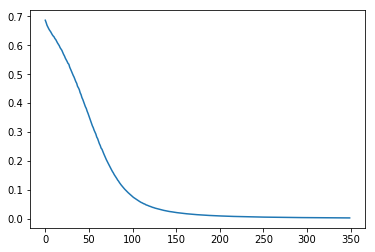

In [4]:
rotulos = []
for i in range(2):
    for j in range(2):
        for k in range(2):
            rotulos.append(model.predict(np.array([[i,j,k]])))

for i in range(len(rotulos)):
    print('Amostra: '+str(x_treino[i])+' - Gabarito: '+str(y_treino[i][0])+' - Estimado: '+str(rotulos[i][0][0]))

plt.plot(Ha.history['loss'])

## Solução da função 2
Fazer regressão não linear é tanto mais complicado. Por isso, faremos uso de uma classe do Keras chamada `KerasRegressor` para nos auxiliar nesta tarefa. Primeiro vamos deixar tudo pronto para usá-la definindo a função que queremos simular e o `modelo()` da rede neural. 

O otimizador configura os vários parâmetros (taxa de aprendizagem e termo momento) presentes numa rede neural. O `adam`, por exemplo, é implementado da seguinte forma:
`keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)`, evidenciando que a taxa de aprendizagem é 0.1% e seu decaimento é 0% por época.

In [5]:
qtd_ponto = 300  # QUANTIDADE DE PONTOS
def objetivo(x):
    return np.cos(2*np.pi*x)*np.sinc(x)/(1-(4*x)**2)

def modelo():
    model= km.Sequential()
    model.add(kl.Dense(60, input_dim=1, kernel_initializer='normal',activation='relu'))
    model.add(kl.Dense(60, kernel_initializer='normal',activation='relu'))
    model.add(kl.Dense(60, kernel_initializer='normal',activation='relu'))
    model.add(kl.Dense(1, kernel_initializer='normal'))  # Se não dissermos a ativação, é usada a linear
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

### Criando dados de treinamento
A rede neural que estamos contruindo deve retornar os valores da função dita anteriormente, logo, os dados de treinamento são valores de x quaisquer e valores calculados de $f(x)$.
O código abaixo criará o vetor com 400 valores de x no intervalo $[0, 4\pi]$ dispersos linearmente e o vetor y será preenchido com elementos $y_{i} = f(x_{i})$.

Os dados são escalados usando a classe StandardScaler().

OBS.: 
**Escalar** um vetor é soma-lo de uma constante e depois multiplica-lo por uma constante.
**Normalizar** um vetor é dividir todos elementos pela sua norma.
**Padronizar** um vetor geralmente significa subtrair um medida de localização (média) e dividir por uma medida de escala (desvio padrão).

Fonte: [Should I normalize/standardize/rescale the data?](http://www.faqs.org/faqs/ai-faq/neural-nets/part2/)

In [6]:
x = np.linspace(0, np.pi, qtd_ponto).reshape(-1, 1)  # cria um vetor coluna
y = objetivo(x)  # Também é vetor coluna
sc_X = StandardScaler()
sc_Y = StandardScaler()
x_treino = sc_X.fit_transform(x)
y_treino = sc_Y.fit_transform(y)

### Construindo rede neural
Aqui criamos um objeto estimador. Seus parâmetros são: 

* Função que modela a rede
* Número de épocas: quantas vezes todos os dados serão aplicados na rede neural
* Tamanho do "batch": quantidade de entradas testadas antes de atualizar os pesos
* verbose: um inteiro indicando o que deve ser impresso na tela, não é essencial ao projeto.

A função `fit()`, além de treinar a rede, retorna um histórico com o valor da função custo de cada época. Custo neste contexto significa diferença entre saída e gabarito, que pode ser calculada de várias maneiras.

In [7]:
monitor = kc.EarlyStopping(monitor='loss', min_delta=0, patience=5, verbose=0, mode='auto')  # Condição de parada do treinamento
estimador = KerasRegressor(build_fn=modelo, epochs=100, batch_size=10, verbose=0)  # quanto menor o batch-size, mais demorado o treino
Hb = estimador.fit(x_treino, y_treino,verbose=0)

### Validação
Mostramos o progresso do erro conforme se passam as épocas.

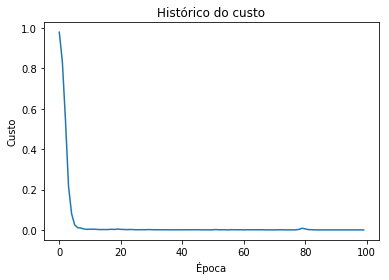

In [8]:
plt.plot(Hb.history['loss'])
plt.xlabel('Época')
plt.ylabel('Custo')
plt.title('Histórico do custo')
plt.show()

Criando dados para validação

In [9]:
interv = (x[1] - x[0])/2  # Metade do intervalo entre dois pontos em x_treino
x_teste = np.linspace(interv, 4*np.pi+interv, qtd_ponto)[np.newaxis].T
y_teste = objetivo(x)

valores_esc = estimador.predict(sc_X.fit_transform(x_teste))  # valores escalados
valores = sc_Y.inverse_transform(valores_esc)

Visualizando resultado. Curva em azul é o gabarito, a verde é o estimado pela rede neural.

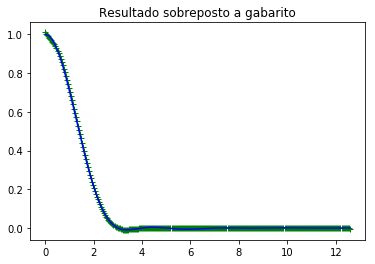

In [10]:
plt.title('Resultado sobreposto a gabarito')
plt.plot(x_teste, valores, 'g+')  # Estimado
plt.plot(x_teste, y_teste, 'b')  # Gabarito
plt.show()

Vamos "dar um zoom" no gráfico para ver de perto o que ocorre de 0 a $2\pi$.

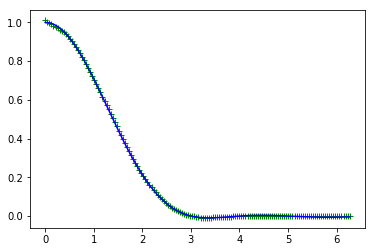

In [11]:
plt.figure()
plt.plot(x_teste[:150], valores[:150], 'g+')  # Estimado
plt.plot(x_teste[:150], y_teste[:150], 'b')  # Gabarito
plt.show()

Vejamos a o erro entre a curva e o valor calculado pela rede em cada x.

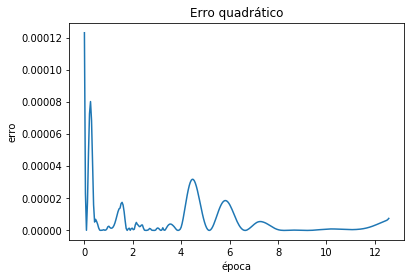

In [13]:
erro = []
for i in range(len(y_teste)):
    erro.append((y_teste[i][0]-valores[i])**2) # erro quadrático
plt.plot(x_teste, erro)
plt.title('Erro quadrático')
plt.xlabel('época')
plt.ylabel('erro')
plt.show()

## Solução da função 3
Vamos visualizar a função objetivo.

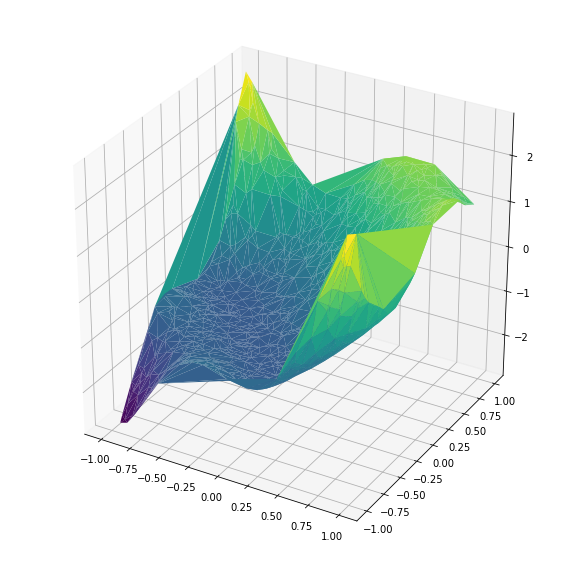

In [14]:
from mpl_toolkits.mplot3d import Axes3D

def objetivo(x,y):
    return x**2 + y**2 + 2*x*y*np.cos(np.pi*x*y) + x + y - 1

def plotsuper(x,y,z, qtd_pts):
    #Plotando função objtetivo
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(x, y, z, cmap=plt.cm.viridis)
    plt.show()

qtd_pts=999
x = np.linspace(-1, 1, qtd_pts)
y = np.random.rand(qtd_pts)*2-1
z = objetivo(x, y)
plotsuper(x,y,z,qtd_pts)

### Gerando dados de treinamento
Vamos criar um vetor de 100 pontos linearmente distribuídos no eixo x e um vetor com valores aleatórios representando as coordenadas y de cada ponto. O vetor z guarda o valor da função em cada ponto (x,y).

Os vetores precisam ter o formato de única coluna pois essa é a forma esperada pelo `Keras`. Por isso usamos a função `reshape(M, N)`, redimensionar o array para uma matriz de MxN. Note que só é obrigatório fornecer um dos valores, o outro é subentendido. Para omiti-lo, escrevemos -1 no lugar.

In [15]:
x = np.linspace(-1, 1, qtd_pts).reshape(-1, 1)
y = np.random.rand(qtd_pts).reshape(-1, 1)*2-1
z = objetivo(x, y)

x = x.reshape(-1,1)
y = y.reshape(-1,1)
z = z.reshape(-1,1)

sc = StandardScaler()
x_treino = sc.fit_transform(x)
y_treino = sc.fit_transform(y)
z_treino = sc.fit_transform(z)

treino = []
for v1,v2 in zip(x_treino, y_treino):
    treino.append([v1[0], v2[0]])
treino = np.array(treino)


### Construindo e treinando rede neural

In [16]:
def modelo():
    model = km.Sequential()
    model.add(kl.Dense(20, input_dim=2, kernel_initializer='normal',activation='relu'))
    model.add(kl.Dense(20, kernel_initializer='normal',activation='relu'))
    model.add(kl.Dense(20, kernel_initializer='normal',activation='relu'))
    model.add(kl.Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

monitor = kc.EarlyStopping(monitor='loss', min_delta=1e-4, patience=5, verbose=0, mode='auto')  # Condição de parada do treinamento
estimador = KerasRegressor(build_fn=modelo, epochs=150, batch_size=5, verbose=1, callbacks=[monitor])
Hc = estimador.fit(treino, z_treino,verbose=0)


### Validação
Vejamos o histórico de erro e depois o gráfico com os dados de teste.

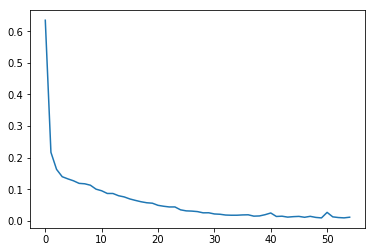

In [17]:
plt.plot(Hc.history['loss'])
plt.show()

999/999 [==============================] - 1s 544us/step


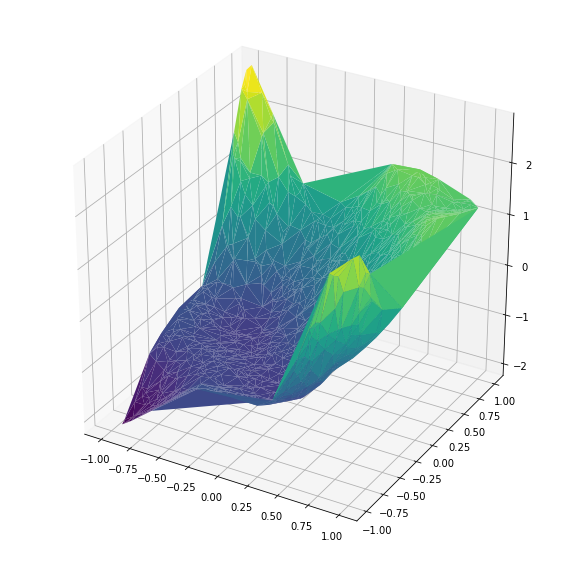

In [18]:
x = np.linspace(-1, 1, qtd_pts).reshape(-1 ,1)
y = np.random.rand(qtd_pts).reshape(-1, 1)*2-1
z = objetivo(x,y)

x_teste = sc.fit_transform(x)
y_teste = sc.fit_transform(y)
z_teste = sc.fit_transform(z)

teste = []
for v1,v2 in zip(x_teste,y_teste):
    teste.append([v1[0], v2[0]])
teste = np.array(teste)

valores_esc = estimador.predict(teste)
valores = sc.inverse_transform(valores_esc)

plotsuper(x.reshape(1,-1)[0], y.reshape(1,-1)[0], valores, 999)
